# COMP0123 Final Report Code

In [40]:
import numpy as np
import pandas as pd

Load Data

In [118]:
data = pd.read_csv("hr_panel_2025.csv", low_memory=False)
data.head()

,acceptanceDatetime,accessionNumber,schemaVersion,cik,submissionType,reportCalendarOrQuarter,isAmendment,amendmentNo,amendmentType,reportType,...,figi,value,sshPrnamt,sshPrnamtType,putCall,investmentDiscretion,otherManager,votingAuthoritySole,votingAuthorityShared,votingAuthorityNone
0,20250417095136,0001085146-25-002155,X0202,1002152,13F-HR,2025-03-31,False,NaN,NaN,13F HOLDINGS REPORT,...,BBG001SCXK90,57505105,184288,SH,NaN,SOLE,NaN,4380,0,179908
1,20250417095136,0001085146-25-002155,X0202,1002152,13F-HR,2025-03-31,False,NaN,NaN,13F HOLDINGS REPORT,...,BBG009S39JY5,54529853,352625,SH,NaN,SOLE,NaN,8277,0,344348
2,20250417095136,0001085146-25-002155,X0202,1002152,13F-HR,2025-03-31,False,NaN,NaN,13F HOLDINGS REPORT,...,BBG001S5NSK6,60156065,917153,SH,NaN,SOLE,NaN,21338,0,895815
3,20250417095136,0001085146-25-002155,X0202,1002152,13F-HR,2025-03-31,False,NaN,NaN,13F HOLDINGS REPORT,...,BBG001S5N8V8,3072058,13830,SH,NaN,SOLE,NaN,0,0,13830
4,20250417095136,0001085146-25-002155,X0202,1002152,13F-HR,2025-03-31,False,NaN,NaN,13F HOLDINGS REPORT,...,BBG001S82KF6,63435361,207624,SH,NaN,SOLE,NaN,5294,0,202330


In [119]:
data.columns

Index(['acceptanceDatetime', 'accessionNumber', 'schemaVersion', 'cik',
       'submissionType', 'reportCalendarOrQuarter', 'isAmendment',
       'amendmentNo', 'amendmentType', 'reportType', 'tableValueTotal',
       'index', 'nameOfIssuer', 'titleOfClass', 'cusip', 'figi', 'value',
       'sshPrnamt', 'sshPrnamtType', 'putCall', 'investmentDiscretion',
       'otherManager', 'votingAuthoritySole', 'votingAuthorityShared',
       'votingAuthorityNone'],
      dtype='object')

- [Column context](#column-context)
    - accessionNumber: The accession number of the filing
    - reportCalendarOrQuarter: The calendar or quarter of the filing
    - cik: The Central Index Key of the investor (investor identifier)
    - nameOfIssuer: The name of the issuer (company)
    - value: The value of the filing
    - sshPrnamt: The number of shares held
    - cusip: The CUSIP of the issuer (company)

In [120]:
# load relevant columns
df = data[['accessionNumber', 'reportCalendarOrQuarter', 'cik', 'nameOfIssuer', 'value', 'sshPrnamt', 'cusip']]
df = df.rename(columns={'cik': 'investor', 'nameOfIssuer': 'company', 'value': 'marketValue', 'sshPrnamt': 'numSharesHeld'})
df = df.dropna()
df.shape

(9549835, 7)

PREPROCESSING

In [121]:
# load coverpage data
coverpage = pd.read_csv('lhr_coverpage.csv', low_memory=False)

# select most recent quarter
latest_quarter = df['reportCalendarOrQuarter'].max()
df_subset = df[df['reportCalendarOrQuarter'] == latest_quarter].copy()

# create unique cusip mapping to fix duplicate company names
cusip_name_map = df_subset.groupby('cusip')['company'].first().to_dict()

# find top 5000 companies by total marketValue
company_totals = df_subset.groupby('cusip').agg({'marketValue': 'sum'}).sort_values(by='marketValue', ascending=False)
top_cusips = company_totals.head(5000).index

# filter the data to include only the top 5000 companies
filtered_holdings = df_subset[df_subset['cusip'].isin(top_cusips)].copy()

# apply the standardized company name and merge with coverpage dataset
filtered_holdings['company'] = filtered_holdings['cusip'].map(cusip_name_map)

merged_df = filtered_holdings.merge(
    coverpage[['accessionNumber', 'filingManagerName']], 
    on='accessionNumber', 
    how='left'
)

merged_df = merged_df.rename(columns={'filingManagerName': 'investorName'})

print(f"{len(merged_df['company'].unique())} unique companies.")
merged_df.head()

3837 unique companies.


,accessionNumber,reportCalendarOrQuarter,investor,company,marketValue,numSharesHeld,cusip,investorName
0,0001056827-25-000006,2025-09-30,1056827,MICROSOFT CORP,334593984,645997,594918104,ARMSTRONG HENRY H ASSOCIATES INC
1,0001056827-25-000006,2025-09-30,1056827,BERKSHIRE HATHAWAY INC DEL,214192800,284,084670108,ARMSTRONG HENRY H ASSOCIATES INC
2,0001056827-25-000006,2025-09-30,1056827,BERKSHIRE HATHAWAY INC DEL,185210874,368403,084670702,ARMSTRONG HENRY H ASSOCIATES INC
3,0001056827-25-000006,2025-09-30,1056827,MOODYS CORP,70822773,148637,615369105,ARMSTRONG HENRY H ASSOCIATES INC
4,0001056827-25-000006,2025-09-30,1056827,JOHNSON & JOHNSON,60782768,327811,478160104,ARMSTRONG HENRY H ASSOCIATES INC


Reveal Investor Names:

Build Bipartite Network using NetworkX Python package

In [122]:
import networkx as nx
import matplotlib.pyplot as plt

cusip_to_name = merged_df.groupby('cusip')['company'].first().to_dict()

# Map these standard names back to a new column
merged_df['standard_company'] = merged_df['cusip'].map(cusip_to_name)

# 'investor' will be one set of nodes, 'company' the other
G_top_5k = nx.from_pandas_edgelist(merged_df, source='investorName', target='standard_company', edge_attr='marketValue')

# Label nodes as bipartite
investor_nodes = set(merged_df['investorName'])
company_nodes = set(merged_df['standard_company'])

nx.set_node_attributes(G_top_5k, {n: 0 for n in investor_nodes}, 'bipartite')
nx.set_node_attributes(G_top_5k, {n: 1 for n in company_nodes}, 'bipartite')

print(f"Nodes: {G_top_5k.number_of_nodes()}, Edges: {G_top_5k.number_of_edges()}")

Nodes: 11807, Edges: 1667321


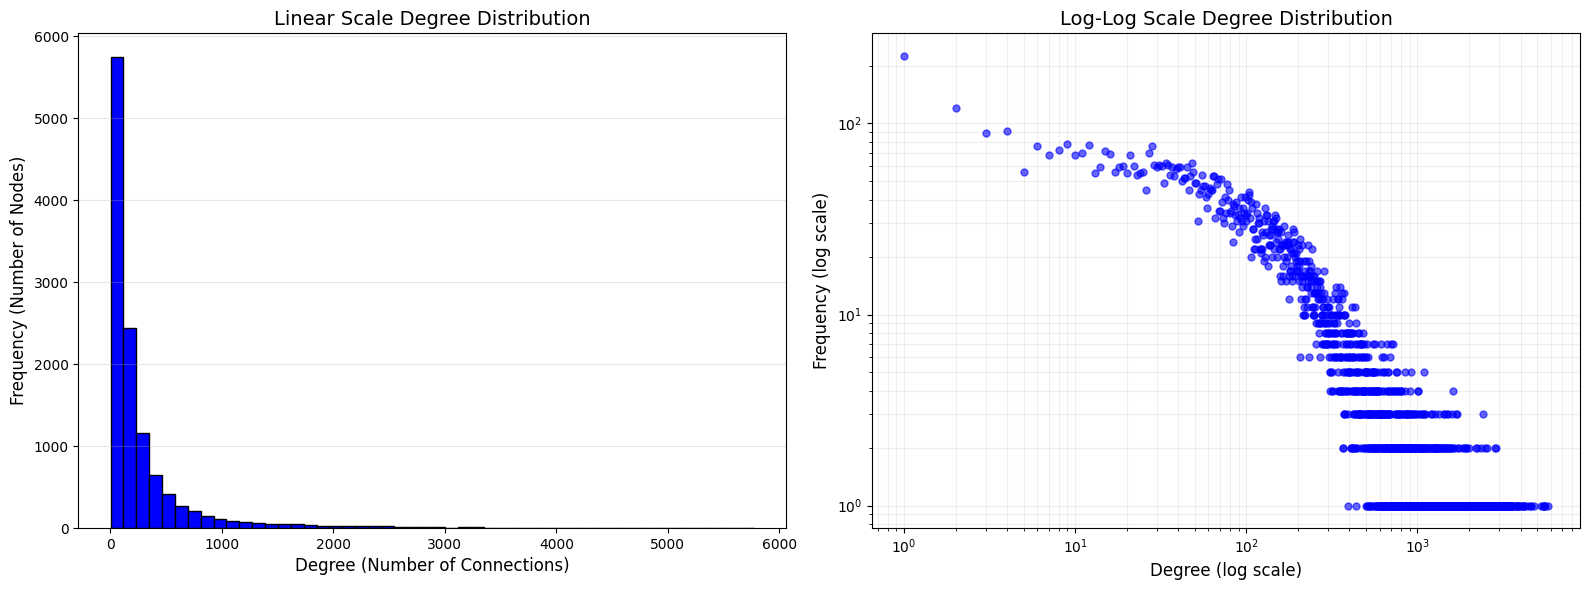

In [123]:
# extract degree values
degrees = [d for n, d in G_top_5k.degree()]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# linear scale
ax1.hist(degrees, bins=50, color='blue', edgecolor='black')
ax1.set_title('Linear Scale Degree Distribution', fontsize=14)
ax1.set_xlabel('Degree (Number of Connections)', fontsize=12)
ax1.set_ylabel('Frequency (Number of Nodes)', fontsize=12)
ax1.grid(axis='y', alpha=0.3)

# log-log scale
degree_counts = pd.Series(degrees).value_counts().sort_index()
ax2.loglog(degree_counts.index, degree_counts.values, 'o', 
           color='blue', markersize=5, alpha=0.6)
ax2.set_title('Log-Log Scale Degree Distribution', fontsize=14)
ax2.set_xlabel('Degree (log scale)', fontsize=12)
ax2.set_ylabel('Frequency (log scale)', fontsize=12)
ax2.grid(True, which="both", ls="-", alpha=0.2)

plt.tight_layout()
plt.savefig('degree_distribution.png', dpi=300)
plt.show()

Draw/Visualize the bipartite graph with labels revealed

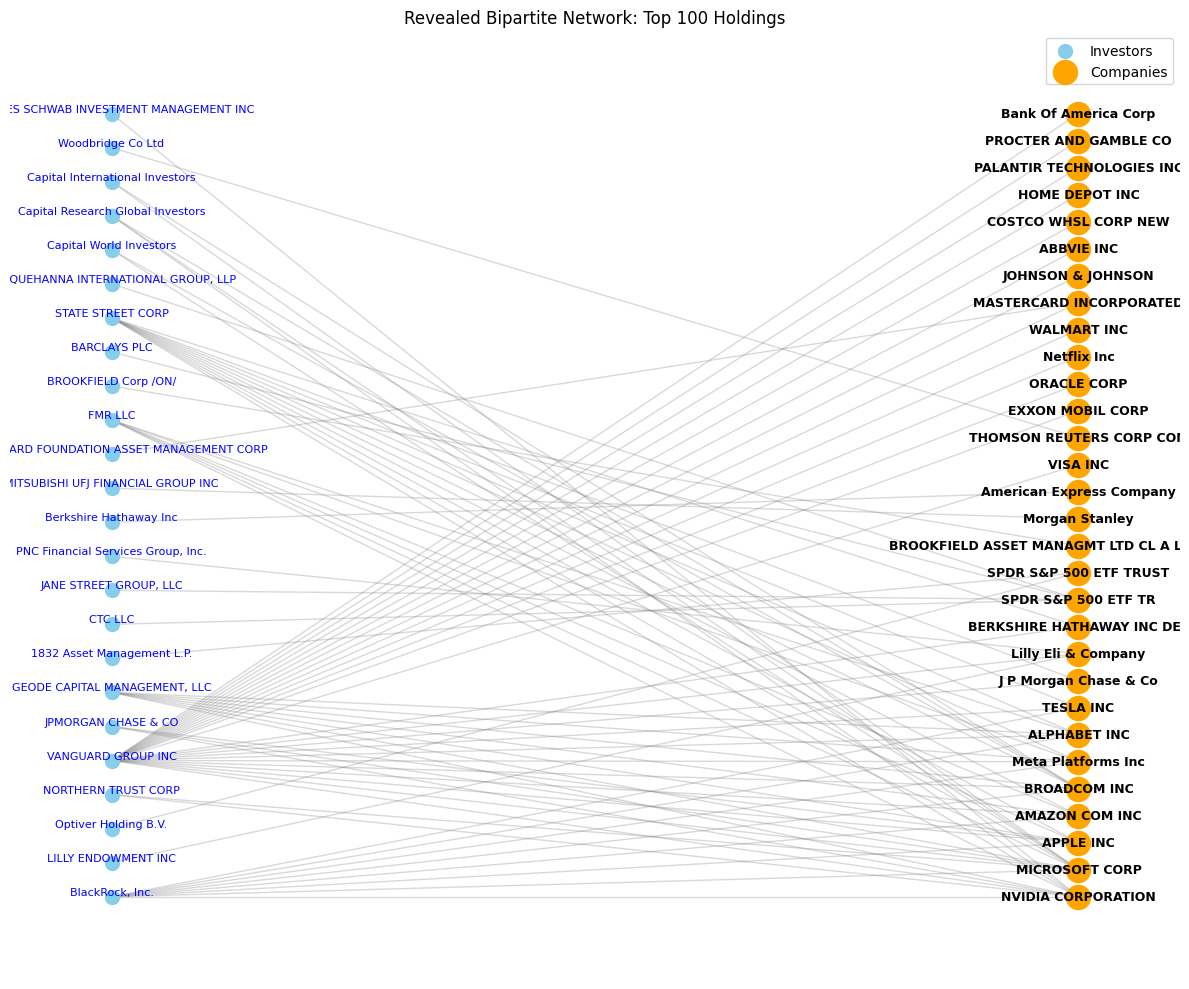

In [124]:
from networkx.algorithms import bipartite

# create a visualization subgraph of the top 100 holdings (5000 runs too slow)
top_100 = merged_df.nlargest(100, 'marketValue')
G_top100_viz = nx.from_pandas_edgelist(top_100, source='investorName', target='company')

# define node sets
top_nodes = {n for n in top_100['investorName']}
bottom_nodes = {n for n in top_100['company']}

# position nodes using the bipartite layout
pos = nx.bipartite_layout(G_top100_viz, top_nodes)

# draw the graph
plt.figure(figsize=(12, 10))

# draw investors and companies
nx.draw_networkx_nodes(G_top100_viz, pos, nodelist=top_nodes, node_color='skyblue', node_size=100, label='Investors')
nx.draw_networkx_nodes(G_top100_viz, pos, nodelist=bottom_nodes, node_color='orange', node_size=300, label='Companies')
nx.draw_networkx_edges(G_top100_viz, pos, alpha=0.3, edge_color='gray')

# draw labels for investors
investor_labels = {n: n for n in top_nodes}
nx.draw_networkx_labels(G_top100_viz, pos, labels=investor_labels, font_size=8, font_color='blue', verticalalignment='bottom')

# draw labels for companies
company_labels = {n: n for n in bottom_nodes}
nx.draw_networkx_labels(G_top100_viz, pos, labels=company_labels, font_size=9, font_weight='bold')

plt.title("Revealed Bipartite Network: Top 100 Holdings")
plt.legend(scatterpoints=1)
plt.axis('off')
plt.tight_layout()
plt.show()

In [145]:
# create a subgraph of the top 5000 holdings
top_500 = merged_df.nlargest(5000, 'marketValue').copy()
# Fix: Create distinct node names to ensure bipartite structure
top_500['investor_node'] = top_500['investorName'].apply(lambda x: f"{x} (Inv)")
top_500['company_node'] = top_500['company'].apply(lambda x: f"{x} (Comp)")
# Use the new columns for the graph
G_top500_viz = nx.from_pandas_edgelist(top_500, source='investor_node', target='company_node', edge_attr='marketValue')
# define node sets
top_nodes = {n for n in top_500['investor_node']}
bottom_nodes = {n for n in top_500['company_node']}
# position nodes using the bipartite layout
pos = nx.bipartite_layout(G_top500_viz, top_nodes)

# Metrics:

### HITS Algorithm

In [146]:
np.random.seed(0)

# run HITS algorithm on your bipartite graph G
hubs, authorities = nx.hits(G_top500_viz)

# convert to a sorted list to find the "blind" top performers
top_authorities = sorted(authorities.items(), key=lambda x: x[1], reverse=True)
print("Top 10 Authorities (Success Prediction):")
for node, score in top_authorities[:10]:
    print(f"{node}: {score}")

print("\n")
# top 10 hubs (influencers)
top_hubs = sorted(hubs.items(), key=lambda x: x[1], reverse=True)
print("Top 10 Hubs (Influencers):")
for node, score in top_hubs[:10]:
    print(f"{node}: {score}")



Top 10 Authorities (Success Prediction):
MICROSOFT CORP (Comp): 0.010468537223573505
NVIDIA CORPORATION (Comp): 0.010224802325002582
APPLE INC (Comp): 0.00984728075911888
AMAZON COM INC (Comp): 0.00938505464315616
ALPHABET INC (Comp): 0.009048520616757264
Meta Platforms Inc (Comp): 0.008652286134808899
BROADCOM INC (Comp): 0.008280226624085755
TESLA INC (Comp): 0.006905684902863939
J P Morgan Chase & Co (Comp): 0.006340610328133038
VISA INC (Comp): 0.006024724932516011


Top 10 Hubs (Influencers):
VANGUARD GROUP INC (Inv): 0.051174485840995675
STATE STREET CORP (Inv): 0.0412961311526289
BlackRock, Inc. (Inv): 0.03671314958757606
GEODE CAPITAL MANAGEMENT, LLC (Inv): 0.02705105717619331
JPMORGAN CHASE & CO (Inv): 0.021879489178825654
FMR LLC (Inv): 0.021392489885271575
Capital World Investors (Inv): 0.018149957951165203
Capital Research Global Investors (Inv): 0.014933288771068844
MORGAN STANLEY (Inv): 0.01487255519364578
WELLINGTON MANAGEMENT GROUP LLP (Inv): 0.014857055600053726


### PageRank

In [147]:
pagerank_scores = nx.pagerank(G_top500_viz)
# sort scores and get top 10
top_pagerank = sorted(pagerank_scores.items(), key=lambda x: x[1], reverse=True)[:50]

print(f'Top 50 nodes by PageRank:')
for node, score in top_pagerank:
    print(f'{node}: {score}')

Top 50 nodes by PageRank:
VANGUARD GROUP INC (Inv): 0.07999825493617391
STATE STREET CORP (Inv): 0.033530736442631257
BlackRock, Inc. (Inv): 0.02424787251978277
NVIDIA CORPORATION (Comp): 0.018014443113620385
MICROSOFT CORP (Comp): 0.01612119240009462
JPMORGAN CHASE & CO (Inv): 0.01484075886471943
GEODE CAPITAL MANAGEMENT, LLC (Inv): 0.013701205647340394
FMR LLC (Inv): 0.012974581380459167
APPLE INC (Comp): 0.012651322623492634
Capital World Investors (Inv): 0.01154129389903431
ISHARES TR (Comp): 0.010152346102165267
AMAZON COM INC (Comp): 0.009677431998754813
Capital International Investors (Inv): 0.009228769073422734
ALPHABET INC (Comp): 0.008629124022745176
Capital Research Global Investors (Inv): 0.008577141445937594
MORGAN STANLEY (Inv): 0.007565500796261565
Meta Platforms Inc (Comp): 0.007519550659895245
WELLINGTON MANAGEMENT GROUP LLP (Inv): 0.007218884484321731
BANK OF AMERICA CORP /DE/ (Inv): 0.006867707341258782
SPDR S&P 500 ETF TR (Comp): 0.006680685782636642
BROADCOM INC (C

### Clustering Coefficients

In [148]:
current_nodes = set(G_top500_viz.nodes())

# determine which are investors vs companies
investors_nodes = {n for n in G_top500_viz.nodes() if n.endswith('(Inv)')}
# find company nodes based on the suffix
company_nodes = {n for n in G_top500_viz.nodes() if n.endswith('(Comp)')}

# explicitly set the attributes on the graph object
nx.set_node_attributes(G_top500_viz, {n: 0 for n in investors_nodes}, 'bipartite')
nx.set_node_attributes(G_top500_viz, {n: 1 for n in company_nodes}, 'bipartite')

# find company nodes
company_nodes = {n for n, d in G_top500_viz.nodes(data=True) if d.get('bipartite') == 1}

# run bipartite clustering
from networkx.algorithms import bipartite
clustering = bipartite.clustering(G_top500_viz, nodes=company_nodes)

print(f"Identified {len(company_nodes)} companies for clustering.")

Identified 676 companies for clustering.


In [149]:
# Convert clustering dictionary to a sorted DataFrame
cluster_df = pd.DataFrame.from_dict(clustering, orient='index', columns=['clustering_score'])
cluster_df = cluster_df.sort_values(by='clustering_score', ascending=False)

print("Top 10 'Crowded' Companies (High Overlap):")
print(cluster_df.head(10))

print("\nTop 5 'Unique' Companies (Low Overlap):")
print(cluster_df.tail(5))

Top 10 'Crowded' Companies (High Overlap):
                                          clustering_score
INGRAM MICRO HLDG CORP COM (Comp)                  1.00000
ICAHN ENTERPRISES LP (Comp)                        1.00000
CVR ENERGY INC COM (Comp)                          1.00000
MCGRAW HILL INC (Comp)                             1.00000
TRIPLE FLAG PRECIOUS METAL (Comp)                  0.60000
SUNCOR ENERGY INC NEW (Comp)                       0.60000
AURORA INNOVATION INC CLASS A COM (Comp)           0.50000
KEYSIGHT TECHNOLOGIES INC (Comp)                   0.46961
KIMCO RLTY CORP (Comp)                             0.46961
METTLER TOLEDO INTERNATIONAL (Comp)                0.46961

Top 5 'Unique' Companies (Low Overlap):
                                clustering_score
BNY MELLON ETF TRUST (Comp)                  0.0
Sector SPDR Indl Select (Comp)               0.0
EQUINOR ASA (Comp)                           0.0
NONE (Comp)                                  0.0
STELLANTIS N.V (Comp) 

### Betweenness Centrality

In [150]:
G_company = bipartite.weighted_projected_graph(G_top500_viz, company_nodes)

# betweenness centrality
betweenness = nx.betweenness_centrality(G_company)
top_betweenness = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:11]
print('Top 10 nodes by betweenness centrality:')
for node, centrality in top_betweenness:
    print(f'{node}: {centrality}')
# Brookfield Corp is an investor

Top 10 nodes by betweenness centrality:
BROOKFIELD CORP CL A LTD VT SH (Comp): 0.01173170458759556
MICROSOFT CORP (Comp): 0.009747859922387291
AMAZON COM INC (Comp): 0.009510760102941298
APPLE INC (Comp): 0.009163415133364994
NVIDIA CORPORATION (Comp): 0.008305610046872459
ALPHABET INC (Comp): 0.007786574979769212
BROADCOM INC (Comp): 0.006752113769512257
Netflix Inc (Comp): 0.0064353432656544165
Meta Platforms Inc (Comp): 0.006057576037111019
PHILLIPS 66 (Comp): 0.005662140073622156
COUPANG INC (Comp): 0.0056357841521046505
